## 3.4使用变分自编码器生成面部图像
本节将使用CelebA数据集来训练变分自编码器，该数据集包含超过200 000张名人的面部图像。每张图像都有40个二进制属性标记，如性别、年龄和发型等，如下图所示。

In [1]:
from time import time
import numpy as np
import pandas as pd
from tqdm import tqdm
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader,random_split
import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToPILImage

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [3]:
#定义一些超参数
#random_seed = 456
#learning_rate = 0.005
#num_epochs = 10
batch_size=256
img_shape=(64,64)
# Hyperparameters
n_epochs = 20
kl_weight = 0.00025
lr = 0.005

In [4]:
transform=transforms.Compose([
    transforms.CenterCrop(128),
    transforms.Resize(img_shape),
    transforms.ToTensor(),
    transforms.
    Normalize(mean=[0.5, 0.5, 0.5],std=[0.5, 0.5, 0.5])
])


#定义数据集路径
data ='../data'

## transforms函数简介

|函数参数|参数说明|
|:-|:-|
|Resize	|把给定的图片resize到given size|
|Normalize	|用均值和标准差归一化张量图像，数据变换到(-1,1)|
|ToTensor	|convert a PIL image to tensor (H*W*C) in range [0,255] to a torch.Tensor(C*H*W) in the range [0.0,1.0]|
|CenterCrop	|在图片的中间区域进行裁剪|
|RandomCrop	|在一个随机的位置进行裁剪|
|FiceCrop	|把图像裁剪为四个角和一个中心|
|RandomResizedCrop	|将PIL图像裁剪成任意大小和纵横比|
|ToPILImage	|convert a tensor to PIL image|
|RandomHorizontalFlip	|以0.5的概率水平翻转给定的PIL图像|
|RandomVerticalFlip	|以0.5的概率竖直翻转给定的PIL图像|
|Grayscale	|将图像转换为灰度图像|
|RandomGrayscale	|将图像以一定的概率转换为灰度图像|
|ColorJitter	|随机改变图像的亮度对比度和饱和度|

## 导入数据
CelebA数据集包含超过200,000张名人的面部图像。每张图像都有40个二进制属性标记，例如性别、年龄和发型等
CelebA拥有的40个属性分别是什么呢？以下是我个人对这四十个属性意义的理解：
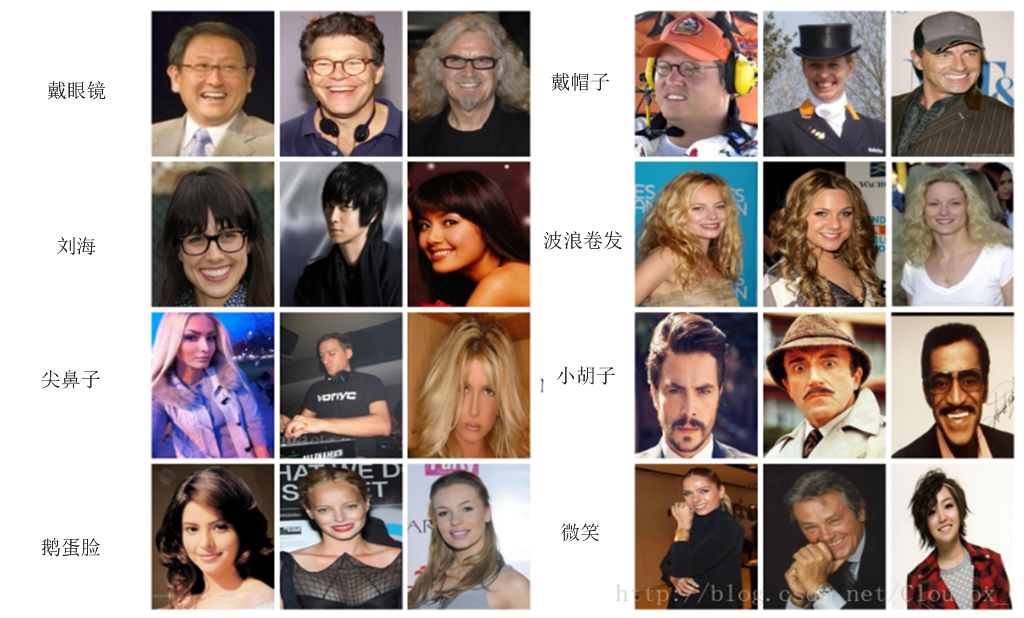

In [5]:
train_dataset=torchvision.datasets.CelebA(root=data,split='train',transform =transform,download=False)
test_dataset=torchvision.datasets.CelebA(root=data,split='test',transform =transform,download=False)


## 把数据转换为批量形式，可防止一次全导入内存

In [6]:
m=len(train_dataset)
train_data, val_data = random_split(train_dataset, [int(m-m*0.2), int(m*0.2)])

# The dataloaders handle shuffling, batching, etc...
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size)
valid_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,shuffle=True)


In [7]:
for images, labels in train_loader:  
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    break

Image batch dimensions: torch.Size([256, 3, 64, 64])
Image label dimensions: torch.Size([256, 40])


## 可视化数据


 np.clip(example_data[i], 0, 1).shape

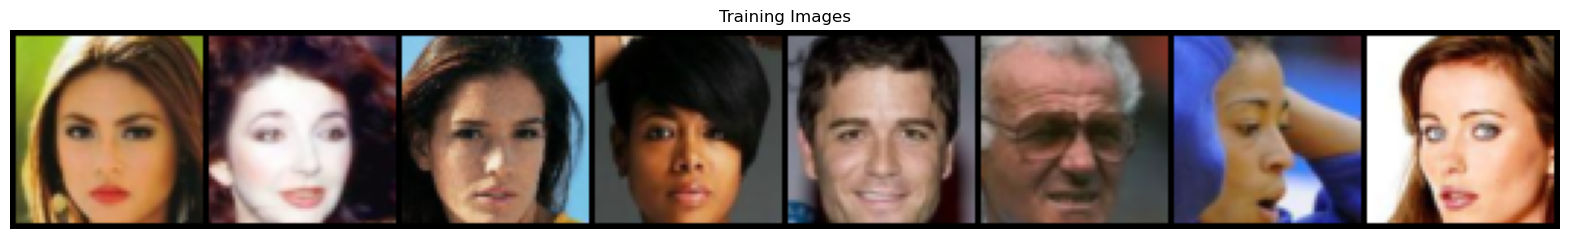

In [8]:
import torchvision.utils as vutils
real_batch = next(iter(test_loader))
plt.figure(figsize=(20,16))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0][:8], padding=2, normalize=True),(1,2,0)))

In [9]:
real_batch[0][:8].shape

torch.Size([8, 3, 64, 64])

## 定义编码器和解码器

In [10]:
class VAE_D(nn.Module):
    def __init__(self,
                 in_channels=3,
                 latent_dim=128,
                 hidden_dims=[32, 64, 128, 256, 512],
                 **kwargs):
        super(VAE_D, self).__init__()

        self.latent_dim = latent_dim

        modules = []
  
        # Build Encoder
        for h_dim in hidden_dims:
            modules.append(
                nn.Sequential(
                    nn.Conv2d(in_channels, out_channels=h_dim,
                              kernel_size= 3, stride= 2, padding  = 1),
                    nn.BatchNorm2d(h_dim),
                    nn.LeakyReLU(),
                    nn.Dropout(p=0.5))
            )
            in_channels = h_dim

        self.encoder = nn.Sequential(*modules)
        self.fc_mu = nn.Linear(hidden_dims[-1]*4, latent_dim)
        self.fc_var = nn.Linear(hidden_dims[-1]*4, latent_dim)


        # Build Decoder
        modules = []

        self.decoder_input = nn.Linear(latent_dim, hidden_dims[-1] * 4)

        hidden_dims.reverse()

        for i in range(len(hidden_dims) - 1):
            modules.append(
                nn.Sequential(
                    nn.ConvTranspose2d(hidden_dims[i],
                                       hidden_dims[i + 1],
                                       kernel_size=3,
                                       stride = 2,
                                       padding=1,
                                       output_padding=1),
                    nn.BatchNorm2d(hidden_dims[i + 1]),
                    nn.LeakyReLU(),
                    nn.Dropout(p=0.5))
            )



        self.decoder = nn.Sequential(*modules)

        self.final_layer = nn.Sequential(
                            nn.ConvTranspose2d(hidden_dims[-1],
                                               hidden_dims[-1],
                                               kernel_size=3,
                                               stride=2,
                                               padding=1,
                                               output_padding=1),
                            nn.BatchNorm2d(hidden_dims[-1]),
                            nn.LeakyReLU(),
                            nn.Conv2d(hidden_dims[-1], out_channels= 3,
                                      kernel_size= 3, padding= 1),
                            nn.Tanh())

    def encode(self, input):
        """
        Encodes the input by passing through the encoder network
        and returns the latent codes.
        :param input: (Tensor) Input tensor to encoder [N x C x H x W]
        :return: (Tensor) List of latent codes
        """
        result = self.encoder(input)
        result = torch.flatten(result, start_dim=1)

        # Split the result into mu and var components
        # of the latent Gaussian distribution
        mu = self.fc_mu(result)
        log_var = self.fc_var(result)

        return [mu, log_var]

    def decode(self, z):
        """
        Maps the given latent codes
        onto the image space.
        :param z: (Tensor) [B x D]
        :return: (Tensor) [B x C x H x W]
        """
        result = self.decoder_input(z)
        result = result.view(-1, 512, 2, 2)
        result = self.decoder(result)
        result = self.final_layer(result)
        return result

    def reparameterize(self, mu, logvar):
        """
        Reparameterization trick to sample from N(mu, var) from N(0,1).
        :param mu: (Tensor) Mean of the latent Gaussian [B x D]
        :param logvar: (Tensor) Standard deviation of the latent Gaussian [B x D]
        :return: (Tensor) [B x D]
        """
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return eps * std + mu

    def forward(self, input, **kwargs):
        mu, log_var = self.encode(input)
        z = self.reparameterize(mu, log_var)
        return  [self.decode(z), mu, log_var]    

## 定义损失函数

In [11]:
def loss_fn(y, y_hat, mean, logvar):
    recons_loss = F.mse_loss(y_hat, y)
    kl_loss = torch.mean(-0.5 * torch.sum(1 + logvar - mean**2 - torch.exp(logvar), 1), 0)
    loss = recons_loss + kl_weight*kl_loss
    return loss

## 训练模型

In [12]:
def train(device,dataloader,model):
    optimizer = torch.optim.Adam(model.parameters(), lr)
    dataset_len = len(dataloader.dataset)

    begin_time = time()
    # train
    for i in range(n_epochs):
        loss_sum = 0
        for x,_ in dataloader:
            x = x.to(device)
            y_hat, mean, logvar = model(x)
            loss = loss_fn(x, y_hat, mean, logvar)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_sum += loss
        loss_sum /= dataset_len
        training_time = time() - begin_time
        minute = int(training_time // 60)
        second = int(training_time % 60)
        print(f'epoch {i}: loss {loss_sum} {minute}:{second}')
        #保存模型参数
        torch.save(model.state_dict(), 'model.pth')

In [13]:
## 运行
model=VAE_D().to(device)
#训练模型
train(device,train_loader,model)

epoch 0: loss 0.0004964805557392538 2:33
epoch 1: loss 0.000321947067277506 4:31
epoch 2: loss 0.00030381279066205025 6:31
epoch 3: loss 0.00029575458029285073 8:32
epoch 4: loss 0.00029075739439576864 10:36
epoch 5: loss 0.00028588136774487793 12:41
epoch 6: loss 0.00028041101177223027 14:47
epoch 7: loss 0.00027597302687354386 16:53
epoch 8: loss 0.000272826524451375 18:59
epoch 9: loss 0.0002707589010242373 21:4
epoch 10: loss 0.000268706789938733 23:9
epoch 11: loss 0.000266694143647328 25:15
epoch 12: loss 0.0002654943964444101 27:20
epoch 13: loss 0.0002639379526954144 29:25
epoch 14: loss 0.0002628816873766482 31:31
epoch 15: loss 0.0002619791484903544 33:37
epoch 16: loss 0.0002610272786114365 35:42
epoch 17: loss 0.00026006370899267495 37:48
epoch 18: loss 0.0002594038378447294 39:53
epoch 19: loss 0.0002586511545814574 42:0


In [56]:
from torchsummary import summary
summary( model.encoder,(3,64,64),device="cuda")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
       BatchNorm2d-2           [-1, 32, 32, 32]              64
         LeakyReLU-3           [-1, 32, 32, 32]               0
           Dropout-4           [-1, 32, 32, 32]               0
            Conv2d-5           [-1, 64, 16, 16]          18,496
       BatchNorm2d-6           [-1, 64, 16, 16]             128
         LeakyReLU-7           [-1, 64, 16, 16]               0
           Dropout-8           [-1, 64, 16, 16]               0
            Conv2d-9            [-1, 128, 8, 8]          73,856
      BatchNorm2d-10            [-1, 128, 8, 8]             256
        LeakyReLU-11            [-1, 128, 8, 8]               0
          Dropout-12            [-1, 128, 8, 8]               0
           Conv2d-13            [-1, 256, 4, 4]         295,168
      BatchNorm2d-14            [-1, 25

In [58]:
from torchsummary import summary
summary( model.decoder,(512,2,2),device="cuda")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 256, 4, 4]       1,179,904
       BatchNorm2d-2            [-1, 256, 4, 4]             512
         LeakyReLU-3            [-1, 256, 4, 4]               0
           Dropout-4            [-1, 256, 4, 4]               0
   ConvTranspose2d-5            [-1, 128, 8, 8]         295,040
       BatchNorm2d-6            [-1, 128, 8, 8]             256
         LeakyReLU-7            [-1, 128, 8, 8]               0
           Dropout-8            [-1, 128, 8, 8]               0
   ConvTranspose2d-9           [-1, 64, 16, 16]          73,792
      BatchNorm2d-10           [-1, 64, 16, 16]             128
        LeakyReLU-11           [-1, 64, 16, 16]               0
          Dropout-12           [-1, 64, 16, 16]               0
  ConvTranspose2d-13           [-1, 32, 32, 32]          18,464
      BatchNorm2d-14           [-1, 32,

## 重构图像

In [45]:
def reconstruct(device, dataloader, model):
    model.eval()
    #batch = next(iter(dataloader))
    batch=next(iter( dataloader))[0][:8]
    x = batch[0:1, ...].to(device)
    output = model(x)[0]
    output = output[0].detach().cpu()
    input = batch[0].detach().cpu()
    combined = torch.cat((output, input), 1)
    plt.imshow(np.transpose(vutils.make_grid(output[:8], padding=2, normalize=True),(1,2,0)))


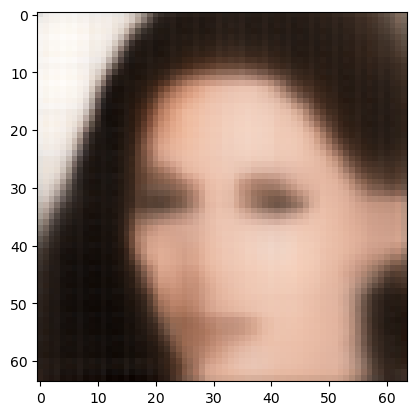

In [50]:
reconstruct(device, test_loader, model)

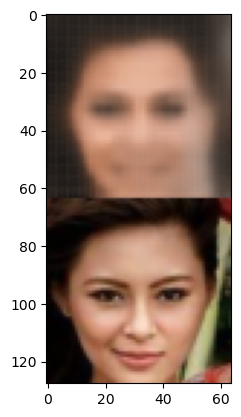

In [35]:
model.eval()
#batch = next(iter(dataloader))
batch=next(iter( test_loader))[0][:8]
x = batch[0:1, ...].to(device)
output = model(x)[0]
output = output[0].detach().cpu()
input = batch[0].detach().cpu()
combined = torch.cat((output, input), 1)
plt.imshow(np.transpose(vutils.make_grid(combined, padding=2, normalize=True),(1,2,0)))

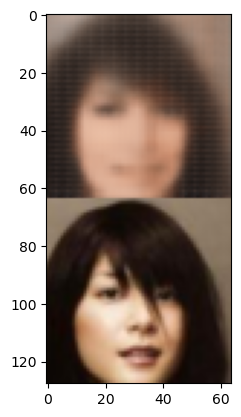

## 从潜空间生成图像

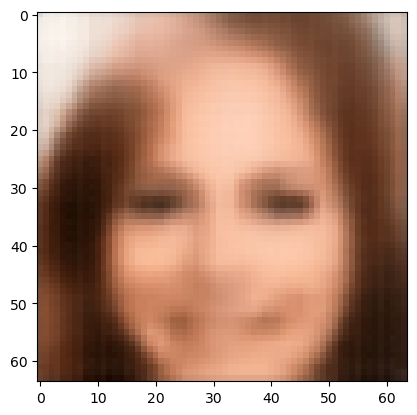

In [36]:
z = torch.randn(1,128)
z = z.to(device)
samples = model.decode(z)
samples=samples.detach().cpu()
plt.imshow(np.transpose(vutils.make_grid(samples, padding=2, normalize=True),(1,2,0)))

## 潜空间的分布

In [51]:
model01= VAE_D().to(device)

In [52]:
batch=next(iter( test_loader))[0][:8]
x = batch.to(device)
mu,logv=model01.encode(x)
z = model01.reparameterize(mu,logv)
z = z.detach().cpu()

In [53]:
import os
from scipy.stats import norm
import pandas as pd

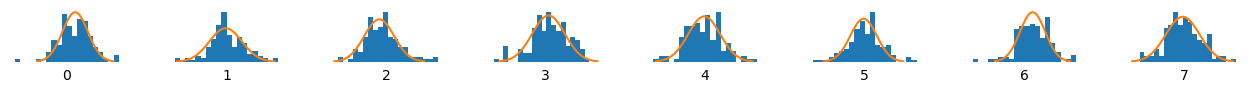

In [54]:
x1 = np.linspace(-3, 3, 100)

fig = plt.figure(figsize=(20, 5))
fig.subplots_adjust(hspace=0.6, wspace=0.4)

for i in range(8):
    ax = fig.add_subplot(5, 10, i + 1)
    ax.hist(z[i,:], density=True, bins=20)
    ax.axis("off")
    ax.text(0.5, -0.35, str(i), fontsize=10, ha="center", transform=ax.transAxes)
    ax.plot(x1, norm.pdf(x1))

plt.show()

## 对隐空间内容添加一些属性

In [60]:
#文件的分隔符是一个或多个空格，第0行为标题
attributes = pd.read_csv("../data/celeba/list_attr_celeba01.txt",engine="python",sep="\s+",header=0)

In [61]:
print(attributes.columns)
attributes.head()

Index(['Image_Id', '5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive',
       'Bags_Under_Eyes', 'Bald', 'Bangs', 'Big_Lips', 'Big_Nose',
       'Black_Hair', 'Blond_Hair', 'Blurry', 'Brown_Hair', 'Bushy_Eyebrows',
       'Chubby', 'Double_Chin', 'Eyeglasses', 'Goatee', 'Gray_Hair',
       'Heavy_Makeup', 'High_Cheekbones', 'Male', 'Mouth_Slightly_Open',
       'Mustache', 'Narrow_Eyes', 'No_Beard', 'Oval_Face', 'Pale_Skin',
       'Pointy_Nose', 'Receding_Hairline', 'Rosy_Cheeks', 'Sideburns',
       'Smiling', 'Straight_Hair', 'Wavy_Hair', 'Wearing_Earrings',
       'Wearing_Hat', 'Wearing_Lipstick', 'Wearing_Necklace',
       'Wearing_Necktie', 'Young'],
      dtype='object')


,Image_Id,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
0,000001.jpg,-1,1,1,-1,-1,-1,-1,-1,-1,...,-1,1,1,-1,1,-1,1,-1,-1,1
1,000002.jpg,-1,-1,-1,1,-1,-1,-1,1,-1,...,-1,1,-1,-1,-1,-1,-1,-1,-1,1
2,000003.jpg,-1,-1,-1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,1,-1,-1,-1,-1,-1,1
3,000004.jpg,-1,-1,1,-1,-1,-1,-1,-1,-1,...,-1,-1,1,-1,1,-1,1,1,-1,1
4,000005.jpg,-1,1,1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,-1,-1,-1,1,-1,-1,1


In [ ]:
model01.encoder()

In [16]:
class VAE_D(nn.Module):
    def __init__(self,
                 in_channels=3,
                 latent_dim=128,
                 hidden_dims=[32, 64, 128, 256, 512],
                 **kwargs):
        super(VAE_D, self).__init__()

        self.latent_dim = latent_dim

        modules = []
  
        # Build Encoder
        for h_dim in hidden_dims:
            modules.append(
                nn.Sequential(
                    nn.Conv2d(in_channels, out_channels=h_dim,
                              kernel_size= 3, stride= 2, padding  = 1),
                    nn.BatchNorm2d(h_dim),
                    nn.LeakyReLU(),
                    nn.Dropout(p=0.5))
            )
            in_channels = h_dim

        self.encoder = nn.Sequential(*modules)
        self.fc_mu = nn.Linear(hidden_dims[-1]*4, latent_dim)
        self.fc_var = nn.Linear(hidden_dims[-1]*4, latent_dim)


        # Build Decoder
        modules = []

        self.decoder_input = nn.Linear(latent_dim, hidden_dims[-1] * 4)

        hidden_dims.reverse()

        for i in range(len(hidden_dims) - 1):
            modules.append(
                nn.Sequential(
                    nn.ConvTranspose2d(hidden_dims[i],
                                       hidden_dims[i + 1],
                                       kernel_size=3,
                                       stride = 2,
                                       padding=1,
                                       output_padding=1),
                    nn.BatchNorm2d(hidden_dims[i + 1]),
                    nn.LeakyReLU(),
                    nn.Dropout(p=0.5))
            )



        self.decoder = nn.Sequential(*modules)

        self.final_layer = nn.Sequential(
                            nn.ConvTranspose2d(hidden_dims[-1],
                                               hidden_dims[-1],
                                               kernel_size=3,
                                               stride=2,
                                               padding=1,
                                               output_padding=1),
                            nn.BatchNorm2d(hidden_dims[-1]),
                            nn.LeakyReLU(),
                            nn.Conv2d(hidden_dims[-1], out_channels= 3,
                                      kernel_size= 3, padding= 1),
                            nn.Tanh())

    def encode(self, input):
        """
        Encodes the input by passing through the encoder network
        and returns the latent codes.
        :param input: (Tensor) Input tensor to encoder [N x C x H x W]
        :return: (Tensor) List of latent codes
        """
        result = self.encoder(input)
        result = torch.flatten(result, start_dim=1)

        # Split the result into mu and var components
        # of the latent Gaussian distribution
        mu = self.fc_mu(result)
        log_var = self.fc_var(result)

        return [mu, log_var]

    def decode(self, z):
        """
        Maps the given latent codes
        onto the image space.
        :param z: (Tensor) [B x D]
        :return: (Tensor) [B x C x H x W]
        """
        result = self.decoder_input(z)
        result = result.view(-1, 512, 2, 2)
        result = self.decoder(result)
        result = self.final_layer(result)
        return result

    def reparameterize(self, mu, logvar):
        """
        Reparameterization trick to sample from N(mu, var) from N(0,1).
        :param mu: (Tensor) Mean of the latent Gaussian [B x D]
        :param logvar: (Tensor) Standard deviation of the latent Gaussian [B x D]
        :return: (Tensor) [B x D]
        """
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return eps * std + mu

    def forward(self, input, **kwargs):
        mu, log_var = self.encode(input)
        z = self.reparameterize(mu, log_var)
        return  [self.decode(z), mu, log_var]    

In [11]:
model2= VAE_D().to(device)

In [12]:
model2.load_state_dict(torch.load('model.pth'))

<All keys matched successfully>

In [13]:
from torchsummary import summary
summary( model2.decoder,(512,2,2),device="cuda")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 256, 4, 4]       1,179,904
       BatchNorm2d-2            [-1, 256, 4, 4]             512
         LeakyReLU-3            [-1, 256, 4, 4]               0
           Dropout-4            [-1, 256, 4, 4]               0
   ConvTranspose2d-5            [-1, 128, 8, 8]         295,040
       BatchNorm2d-6            [-1, 128, 8, 8]             256
         LeakyReLU-7            [-1, 128, 8, 8]               0
           Dropout-8            [-1, 128, 8, 8]               0
   ConvTranspose2d-9           [-1, 64, 16, 16]          73,792
      BatchNorm2d-10           [-1, 64, 16, 16]             128
        LeakyReLU-11           [-1, 64, 16, 16]               0
          Dropout-12           [-1, 64, 16, 16]               0
  ConvTranspose2d-13           [-1, 32, 32, 32]          18,464
      BatchNorm2d-14           [-1, 32,

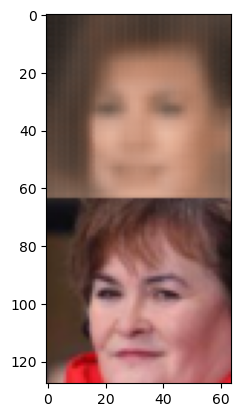

In [14]:
model2.eval()
#batch = next(iter(dataloader))
batch=next(iter( test_loader))[0][:8]
x = batch[0:1, ...].to(device)
output = model2(x)[0]
output = output[0].detach().cpu()
input = batch[0].detach().cpu()
combined = torch.cat((output, input), 1)
plt.imshow(np.transpose(vutils.make_grid(combined, padding=2, normalize=True),(1,2,0)))

In [ ]:
model2.eval()
#batch = next(iter(dataloader))
batch=next(iter( test_loader))[0][:8]
x = batch[0:1, ...].to(device)
output = model2(x)[0]
output = output[0].detach().cpu()
input = batch[0].detach().cpu()
combined = torch.cat((output, input), 1)
plt.imshow(np.transpose(vutils.make_grid(combined, padding=2, normalize=True),(1,2,0)))

In [19]:
model2.eval()
#batch = next(iter(dataloader))
batch=next(iter( test_loader))[0][:8]
_,axes=plt.subplots

torch.Size([8, 3, 64, 64])
torch.Size([1, 3, 64, 64])


In [21]:
x1 = batch[1:2, ...].to(device)
print(x1.size())

torch.Size([1, 3, 64, 64])


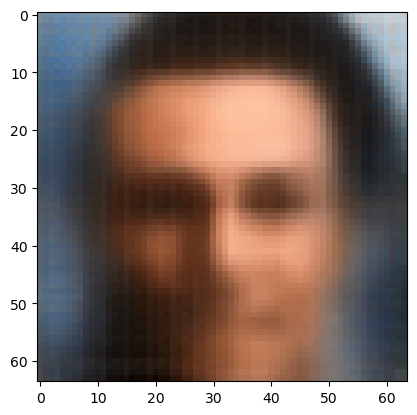

In [25]:
z = torch.randn(1,128)
z = z.to(device)
samples = model2.decode(z)
samples=samples.detach().cpu()
plt.imshow(np.transpose(vutils.make_grid(samples, padding=2, normalize=True),(1,2,0)))